In [1]:
import cv2
import numpy as np

# import image
image = cv2.imread('input.png')

# grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cv2.imshow('gray', gray)

# binary
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
#cv2.imshow('threshold', thresh)

# dilation
kernel = np.ones((10, 10), np.uint8)
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
#cv2.imshow('dilated', img_dilation)

# find contours
# cv2.findCountours() function changed from OpenCV3 to OpenCV4: now it have only two parameters instead of 3
cv2MajorVersion = cv2.__version__.split(".")[0]
# check for contours on thresh
if int(cv2MajorVersion) >= 4:
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
else:
    im2, ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

for i, ctr in enumerate(sorted_ctrs):
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)

    # Getting ROI
    roi = image[y:y + h, x:x + w]

    # show ROI
    # cv2.imshow('segment no:'+str(i),roi)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), 2)

    if w > 15 and h > 15:
        cv2.imwrite('images//{}.png'.format(i), roi)

cv2.imshow('marked areas', image)
cv2.waitKey(0)

-1

In [2]:
# Load as greyscale

import cv2
import numpy as np
from commonfunctions import *
from scipy.stats import iqr
from scipy import stats
from collections import namedtuple
from dataclasses import dataclass






def getHorizontalProjectionProfile(image):
    horizontal_projection = np.sum(image, axis = 1) 
    return horizontal_projection 

def getVerticalProjectionProfile(image):
    vertical_projection = np.sum(image, axis = 0) 
    return vertical_projection 

def Visualize_Histogram(histogram,range_max):
    # # Create output image same height as text, 500 px wide
    m = np.max(histogram)
    w = 27
    result = np.zeros((histogram.shape[0],27))
    # # Draw a line for each row
    for row in range(range_max):
          cv2.line(result, (row,0), (int(histogram[row]*w/m),row), (255,255,255), 1)
    show_images([result.astype(np.uint8())],["result"])        

#vertical_projection = getVerticalProjectionProfile(thresh.copy()) 
#Visualize_Histogram(vertical_projection,vertical_projection.shape[0])

def FindGapSpaceLocation(Line):#ALG2
    VerticalProjection = getVerticalProjectionProfile(Line.copy())
    flag=0
    i=1
    G=[]
    L=[]
    while i < len(VerticalProjection):
        if VerticalProjection[i] == 0 and flag == 0:
            G.append(i)
            print(G)
            print(i)
            L.append( G[i] - G[i-1] )
            flag = 1
        elif VerticalProjection[i] != 0 and flag ==1:
            flag=0
        i+=1
    return G,L

def GapLengthFilteration(G,L):#ALG3
    iqrValue=iqr(L, rng=(25,75), interpolation='midpoint')
    i = 1
    while i < len(L):
        if L[i] != 0 and L[i] < iqrValue:
            del G[i]
            del L[i]
        i+=1
        
    meanValue = np.mean(L)
    i=1
    while i < len(L):
        if L[i] < meanValue:
            del G[i]
        i+=1
    return G,L


In [3]:
def FindBaselineIndex(line): #Alg. 4
    HP = []
    PV = []
    BaseLineIndex = 0
    thresh,thresh_img = cv2.threshold(line,127,255,cv2.THRESH_BINARY_INV)
    thresh_img = np.asarray(thresh_img)
    thresh_img = line

    HP = np.sum(thresh_img, axis = 1)
    PV_Indices = (HP > np.roll(HP,1)) & (HP > np.roll(HP,-1))
    for i in range(len(PV_Indices)):
        if PV_Indices[i] == True:
            PV.append(HP[i])
    #print(PV)
    MAX = max(PV)
    for i in range(len(HP)):
        if HP[i] == MAX:
            BaseLineIndex = i
#     print(BaseLineIndex)
#     cv2.line(thresh_img, (0, BaseLineIndex), (thresh_img.shape[1], BaseLineIndex), (255,255,255), 1)
#     cv2.imshow('binary',thresh_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return BaseLineIndex
    
    
def FindingMaxTrans(Line, BaseLineIndex): #Alg. 5
    MaxTrans = 0
    MaxTransIndex = BaseLineIndex
    i=BaseLineIndex
    while i > 0:
        CurrTrans = 0
        Flag = 0
        j=0
        while j < Line.shape[1]:
            if Line[i, j] == 1 and Flag == 0:
                CurrTrans += 1
                Flag = 1
            if Line[i, j] != 1 and Flag == 1:
                Flag = 0
            j += 1

        if CurrTrans >= MaxTrans:
            MaxTrans = CurrTrans
            MaxTransIndex = i
        i -= 1
    
#     cv2.line(Line, (0, MaxTransIndex), (Line.shape[1], MaxTransIndex), (50,100,150), 1)
#     cv2.imshow('binary',Line)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return MaxTransIndex

In [4]:

@dataclass
class SeparationRegions:
    StartIndex: int=0
    EndIndex: int=0
    CutIndex: int=0

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
    
    
    
#def CutPointIdentification(Line,Word,MTI): #Alg. 6
def CutPointIdentification(Word,MTI): #Alg. 6 ACCORDING TO THE PSEUDO CODE
    Flag=0
    #LineImage=cv2.imread(Line)
    VP=getVerticalProjectionProfile(Word)
    #MFV = stats.mode(VP)
    VPList = VP.tolist() #to be able to get the MFV
    Beginindex=0#ka2eni bashel el goz2 el black eli 3la el edges fl sora 3ashan ageb mode value mazbota
    EndIndex=len(VPList)
    for i in VPList:
        if i ==0:
            Beginindex+=1
        else:
            break
    for j in range(-1,-30,-1):
        if VPList[j]==0:
            EndIndex-=1
        else:
            break


    i=1
    VPListNew = VPList[Beginindex:EndIndex]
    MFV = max(set(VPListNew), key = VPListNew.count) 
    OutputSeparationRegions= []
    SRAppendFlag=False #initialize but do not append
    while i < Word.shape[1] :
        if SRAppendFlag == False:
            SR = SeparationRegions()
            SRAppendFlag = True
        if Word[MTI,i] == 1 and Word[MTI,i+1] == 0 and Flag == 0 : #CALCULATE END INDEX
            SR.EndIndex = i
            Flag = 1
        if i == (Word.shape[1]-1):
            break
        if Word[MTI,i] == 0 and Word[MTI,i+1] == 1 and Flag == 1 : #CALCULATE START AND CUT INDEX
            SR.StartIndex = i+1
            MidIndex = ( SR.EndIndex + SR.StartIndex )/2
            MidIndex = int(MidIndex)
            IndexesEqualZero = np.where(VP == 0)
            IndexesEqualZero = np.asarray(IndexesEqualZero)
            IndexesEqualZero = IndexesEqualZero.tolist()
            IndexesEqualZero = IndexesEqualZero[0]
            IndexesEqualZero = np.array(IndexesEqualZero)
            #print(IndexesEqualZero)
            IndexesCorrect= IndexesEqualZero [ (IndexesEqualZero < SR.StartIndex) & (IndexesEqualZero > SR.EndIndex)] #condition shall be reversed like this
            #IndexesCorrect = IndexesEqualZero[ mask ]
            #print(IndexesEqualZero [ (IndexesEqualZero < SR.StartIndex) & (IndexesEqualZero > SR.EndIndex)])

            IndexesLessThanMFVAndEnd = np.where( (VP <= MFV) )
            IndexesLessThanMFVAndEnd = np.asarray(IndexesLessThanMFVAndEnd)
            IndexesLessThanMFVAndEnd=IndexesLessThanMFVAndEnd.tolist()
            IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd[0]
            IndexesLessThanMFVAndEnd = np.array(IndexesLessThanMFVAndEnd)
            IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd [ (IndexesLessThanMFVAndEnd > SR.EndIndex) & (IndexesLessThanMFVAndEnd < MidIndex)  ]
            #IndexesLessThanMFVAndEnd.append(2)

            IndexesLessThanMFVAndStartAndEnd = np.where( (VP <= MFV) )
            IndexesLessThanMFVAndStartAndEnd = np.asarray(IndexesLessThanMFVAndStartAndEnd)
            IndexesLessThanMFVAndStartAndEnd=IndexesLessThanMFVAndStartAndEnd.tolist()
            IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd[0]
            IndexesLessThanMFVAndStartAndEnd = np.array(IndexesLessThanMFVAndStartAndEnd)
            IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd [ (IndexesLessThanMFVAndStartAndEnd > SR.EndIndex) & (IndexesLessThanMFVAndStartAndEnd < SR.StartIndex) ]
            

            if len(IndexesCorrect) != 0: #neither connected nor overlapped characters
                SR.CutIndex = find_nearest(IndexesCorrect , MidIndex)

            elif VP[MidIndex] == MFV: #connected characters
                SR.CutIndex = MidIndex #line 19 on Alg.
            
            elif len(IndexesLessThanMFVAndEnd) != 0: 
                SR.CutIndex = find_nearest(IndexesLessThanMFVAndEnd , MidIndex)
            
            elif len(IndexesLessThanMFVAndStartAndEnd) != 0: #line 23
                SR.CutIndex = find_nearest(IndexesLessThanMFVAndStartAndEnd , MidIndex)
            else:
                SR.CutIndex = MidIndex
            
            if SRAppendFlag == True:
                OutputSeparationRegions.append(SR)
                SRAppendFlag = False
            Flag = 0
        i+=1
    return OutputSeparationRegions,MFV

In [5]:
def DetectHoles(Word, NextCut, CurrentCut, PreviousCut, MTI):#next is left, previous is right
    LefPixelIndex = 0
    for i in range(NextCut, PreviousCut, 1):
        if Word[MTI, i] == 1:
            LefPixelIndex = i
            break
    
    RightPixelIndex = 0
    for i in range(PreviousCut, NextCut, -1):
        if Word[MTI, i] == 1:
            RightPixelIndex = i
            break
    
    UpPixelIndex = 0
    for i in range(MTI, MTI - 10, -1):
        if Word[i, CurrentCut] == 1:
            UpPixelIndex = i
            break
    
    DownPixelIndex = 0
    for i in range(MTI, MTI + 10, 1):
        if Word[i, CurrentCut+1] == 1: #+1 da psecial case 3ashan law 7arf el heh
            DownPixelIndex = i
            break
    
    if ( np.abs(LefPixelIndex - RightPixelIndex) <=8 ) and ( np.abs(UpPixelIndex - DownPixelIndex ) <=5 ):
        return True
    else:
        return False
    
def DetectBaselineBetweenStartAndEnd(Word, BaseLineIndex, Start, End):#End is left
    if np.sum( Word[BaseLineIndex,End:Start] ) == 0:
        return True #no path found
    return False

def DistanceBetweenTwoPoints(x2,x1):
    dist = np.abs(x2 - x1) 
    return dist

def CheckLine19Alg7(SRL,SR, NextCutIndex, VP, Word,MTI,BaseLineIndex):
    LeftPixelCol = SR.EndIndex
    TopPixelIndex = 0
    for i in range(MTI,MTI-20,-1):
        if Word[i-1,LeftPixelCol] == 0:
            TopPixelIndex = i
            break
    Dist1 = DistanceBetweenTwoPoints( TopPixelIndex,BaseLineIndex )
    Dist2 = DistanceBetweenTwoPoints( MTI,BaseLineIndex )
    if ( SR==SRL[0] and VP[NextCutIndex] == 0) or ( Dist1 < (0.5*Dist2) ) :
        return True
    return False
        
def CheckStroke(Word, NextCut, CurrentCut, PreviousCut, MTI,BaseLineIndex,SR):
    HPAbove = getHorizontalProjectionProfile( Word[0:BaseLineIndex,SR.EndIndex:SR.StartIndex] )
    HPBelow = getHorizontalProjectionProfile( Word[BaseLineIndex: ,SR.EndIndex:SR.StartIndex] )
            
    SHPB = np.sum(HPBelow)
    SHPA = np.sum(HPAbove)
    
    TopPixelIndex = 0
    LeftPixelCol = SR.EndIndex
    for i in range(MTI,MTI-20,-1):
        if Word[i-1,LeftPixelCol] == 0:
            TopPixelIndex = i
            break
            
    Dist1 = DistanceBetweenTwoPoints( TopPixelIndex,BaseLineIndex )
    Dist1 = int(Dist1)
    print(Dist1)
    #HP = getHorizontalProjectionProfile(Word)
    HP = getHorizontalProjectionProfile(Word[:,SR.EndIndex:SR.StartIndex])
    HPList = HP.tolist()
    HPMode = max(set(HPList), key = HPList.count) 
    HPList.sort()
    SecondPeakValue = HPList[-2]
    
    VP=getVerticalProjectionProfile(Word)
    VPList = VP.tolist()
    MFV = max(set(VPList), key = VPList.count) 
    
    Holes = DetectHoles(Word, NextCut, CurrentCut, PreviousCut, MTI)
    if SHPA > SHPB and not Holes:#and (HPMode == MFV) and Dist1 <= (2*SecondPeakValue):
        return True
    return False

def CheckDotsAboveOrBelow(Word, SR, MTI,BaseLineIndex):
    Dots = False
    for i in range(MTI-2, MTI-6, -1):
        for j in range(SR.EndIndex+1, SR.StartIndex):
            if Word[i, j] == 1:
                Dots = True
                return Dots
    for i in range(BaseLineIndex+2, BaseLineIndex+6, 1):
        for j in range(SR.EndIndex+1, SR.StartIndex):
            if Word[i, j] == 1:
                Dots = True
                return Dots
    return Dots
    

    
    

In [6]:
def SeparationRegionFilteration(Word, SRL, BaseLineIndex, MTI, MFV): #Alg. 7
    i=0
    VP=getVerticalProjectionProfile(Word)
    ValidSeparationRegions = []
    while i < len(SRL):
        SR = SRL[i]
        StartEndPath = Word[BaseLineIndex, SR.EndIndex+1 :SR.StartIndex]
        #print(not(1 in StartEndPath))
        PrevIndex = i-1
        NextIndex = i+1
        
        if VP[SR.CutIndex]==0:
            ValidSeparationRegions.append(SR)
            i+=1
        #elif DetectHoles(Word, SRL[PrevIndex].CutIndex, SR.CutIndex, SRL[NextIndex].CutIndex, MTI):
        elif DetectHoles(Word, SR.EndIndex, SR.CutIndex, SR.StartIndex, MTI):
                i+=1
        elif not(1 in StartEndPath):
            ValidSeparationRegions.append(SR)
            i+=1
        elif DetectBaselineBetweenStartAndEnd(Word, BaseLineIndex, SR.StartIndex, SR.EndIndex):
            HPAbove = getHorizontalProjectionProfile( Word[0:BaseLineIndex,SR.EndIndex:SR.StartIndex] )
            HPBelow = getHorizontalProjectionProfile( Word[BaseLineIndex: ,SR.EndIndex:SR.StartIndex] )
            
            SHPB = np.sum(HPBelow)
            SHPA = np.sum(HPAbove)
            
            if SHPB > SHPA :
                i+=1
            elif VP[ SR.CutIndex ] < MFV : #check sign later
                ValidSeparationRegions.append(SR)
                i+=1
            else:
                i+=1
        elif NextIndex >= len(SRL):
            if not DetectHoles(Word, SR.EndIndex, SR.CutIndex, SR.StartIndex, MTI):
                ValidSeparationRegions.append(SR)
            break
        #next is line 19 in Alg.
        elif CheckLine19Alg7(SRL,SR, SRL[i+1].CutIndex, VP, Word,MTI,BaseLineIndex):
            i+=1
        #line 22
        elif not CheckStroke(Word, SRL[i+1].CutIndex, SR.CutIndex, SRL[i-1].CutIndex, MTI,BaseLineIndex,SR) :
            DetectLine = DetectBaselineBetweenStartAndEnd(Word, BaseLineIndex, SRL[i+1].StartIndex, SRL[i+1].EndIndex)
            if ~DetectLine and SRL[i+1].CutIndex <= MFV:
                i+=1
            else:
                ValidSeparationRegions.append(SR)
                i+=1 #line 27
        elif CheckStroke(Word, SRL[i+1].CutIndex, SR.CutIndex, SRL[i-1].CutIndex, MTI,BaseLineIndex,SR) and CheckDotsAboveOrBelow(Word, SR, MTI,BaseLineIndex):#line 29
            ValidSeparationRegions.append(SR)
            i+=1 
            #i+=2#law kan 7arf seen fl nos masln
        elif CheckStroke(Word, SRL[i+1].CutIndex, SR.CutIndex, SRL[i-1].CutIndex, MTI,BaseLineIndex,SR) and not  CheckDotsAboveOrBelow(Word, SR, MTI,BaseLineIndex) :#line 31
            next1 = i+1
            next2 = i+2
            next3 = i+3
            if next1 >= len(SRL) or next2 >= len(SRL) or next3 >= len(SRL):
                ValidSeparationRegions.append(SR)
                i+=1
                continue
            if CheckStroke(Word, SRL[i+2].CutIndex, SRL[i+1].CutIndex, SRL[i].CutIndex, MTI,BaseLineIndex,SRL[i+1]) and CheckDotsAboveOrBelow(Word, SRL[i+1], MTI,BaseLineIndex) :
                ValidSeparationRegions.append(SR)
                i+=3
            else:
                SEGNStroke    = CheckStroke(Word, SRL[i+2].CutIndex, SRL[i+1].CutIndex, SRL[i].CutIndex, MTI,BaseLineIndex,SRL[i+1]) 
                SEGNDots      = CheckDotsAboveOrBelow(Word, SRL[i+1], MTI,BaseLineIndex)
                SEGNNStroke   =  CheckStroke(Word, SRL[i+3].CutIndex, SRL[i+2].CutIndex, SRL[i+1].CutIndex, MTI,BaseLineIndex,SRL[i+2])
                SEGNNDOTSDots = CheckDotsAboveOrBelow(Word, SRL[i+2], MTI,BaseLineIndex)
                if SEGNStroke and SEGNNStroke and (SEGNNDOTSDots or SEGNDots): #di law true yeb2a seen aw sheen masln
                    ValidSeparationRegions.append(SR)
                    i+=3
                else: #7arf noon masln
                    ValidSeparationRegions.append(SR)
                    i+=1
    return ValidSeparationRegions 

12
Seeing Cut Point Identification
10
10
10
3
3
2
2
4
4
3
3
3
3
[SeparationRegions(StartIndex=11, EndIndex=3, CutIndex=7), SeparationRegions(StartIndex=16, EndIndex=11, CutIndex=13), SeparationRegions(StartIndex=25, EndIndex=21, CutIndex=23), SeparationRegions(StartIndex=31, EndIndex=26, CutIndex=28), SeparationRegions(StartIndex=35, EndIndex=31, CutIndex=33), SeparationRegions(StartIndex=39, EndIndex=35, CutIndex=38), SeparationRegions(StartIndex=43, EndIndex=40, CutIndex=41)]


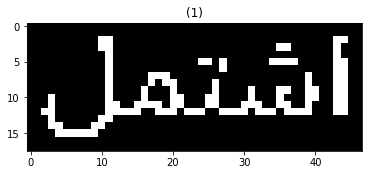

In [7]:
#TESTING ALG 4, 5, 6, 7
im = cv2.imread('images/70.png', cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY_INV)
#cv2.imshow('str',thresh/255)   
BaselineIndex = FindBaselineIndex(thresh)
print(BaselineIndex)
# for i in range(25):
#     for j in range(673):
#         print(thresh[i,j])
MaxTransitionIndex = FindingMaxTrans(thresh/255, BaselineIndex)
# print("max")
# print(MaxTransitionIndex)

SeparationRegions,MFV = CutPointIdentification(thresh/255, MaxTransitionIndex)
print("Seeing Cut Point Identification")
# for SR in SeparationRegions:
#     cv2.line(thresh, (BaselineIndex, SR.StartIndex), (BaselineIndex, SR.StartIndex+1), (0, 20, 200), 10)
#     print(SR.StartIndex)
#     print(SR.EndIndex)
#     print(SR.CutIndex)
#     print("*********")
cv2.imshow('Window', thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

ValidSeparationRegions = SeparationRegionFilteration(thresh/255, SeparationRegions, BaselineIndex, 
                                                     MaxTransitionIndex, MFV)
print(ValidSeparationRegions)

show_images([thresh])
#2, 7, 10,11,12,13, 15, 17, 19,  21, 22, 23, 26, 28, 29, 30, 31 ok
#14(one extra region fl ظ i ), 16(one error in لا i), 18(one extra region in ذ i)
#24(one missing region between م and ف i), 25(one error in teh marbota)

In [ ]:


#vertical_projection = getVerticalProjectionProfile(im) 
  
#Visualize_Histogram(histogram(vertical_projection),vertical_projection.shape[0])

In [ ]:
# import matplotlib.pyplot as plt

# im = cv2.imread('102.png', cv2.IMREAD_GRAYSCALE)

# im = 255-im

# img_row_sum = np.sum(im,axis=0).tolist()

# plt.plot(img_row_sum)
# plt.show()

In [ ]:
def CutPointIdentification(Word,MTI): #Alg. 6 TRY 2 From Paper Explanation
    Flag=0
    #LineImage=cv2.imread(Line)
    VP=getVerticalProjectionProfile(Word)
    #MFV = stats.mode(VP)
    VPList = VP.tolist() #to be able to get the MFV
    Beginindex=0#ka2eni bashel el goz2 el black eli 3la el edges fl sora 3ashan ageb mode value mazbota
    EndIndex=len(VPList)
    for i in VPList:
        if i ==0:
            Beginindex+=1
        else:
            break
    for j in range(-1,-30,-1):
        if VPList[j]==0:
            EndIndex-=1
        else:
            break


    i=1
    VPListNew = VPList[Beginindex:EndIndex]
    MFV = max(set(VPListNew), key = VPListNew.count) 
    OutputSeparationRegions= []
    SRAppendFlag=False #initializa but do not append
    while i < Word.shape[1] :
        if SRAppendFlag == False:
            SR = SeparationRegions()
            SRAppendFlag = True
        if Word[MTI,i] == 1 and Word[MTI,i+1] == 0 and Flag == 0 : #CALCULATE END INDEX
            SR.EndIndex = i
            Flag = 1
        if Word[MTI,i-1] == 0 and Word[MTI,i] == 1 and Flag == 1 : #CALCULATE START AND CUT INDEX
            SR.StartIndex = i
            MidIndex = ( SR.EndIndex + SR.StartIndex )/2
            MidIndex = int(MidIndex)
            IndexesEqualZero = np.where(VP == 0)
            IndexesEqualZero = np.asarray(IndexesEqualZero)
            IndexesEqualZero = IndexesEqualZero.tolist()
            IndexesEqualZero = IndexesEqualZero[0]
            IndexesEqualZero = np.array(IndexesEqualZero)
            #print(IndexesEqualZero)
            IndexesCorrect= IndexesEqualZero [ (IndexesEqualZero < SR.StartIndex) & (IndexesEqualZero > SR.EndIndex)] #condition shall be reversed like this
            #IndexesCorrect = IndexesEqualZero[ mask ]
            #print(IndexesEqualZero [ (IndexesEqualZero < SR.StartIndex) & (IndexesEqualZero > SR.EndIndex)])

            #Line 20 and 21
            #IndexesLessThanMFVAndEnd = np.where( (VP <= MFV) )
            IndexesLessThanMFVAndEnd = np.where( VP >= MFV )
            IndexesLessThanMFVAndEnd = np.asarray(IndexesLessThanMFVAndEnd)
            IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd.tolist()
            IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd[0]
            IndexesLessThanMFVAndEnd = np.array(IndexesLessThanMFVAndEnd)
            IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd [ IndexesLessThanMFVAndEnd > SR.EndIndex ]
            #IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd[0]
            #IndexesLessThanMFVAndEnd.append(2)

            #for line 23 and 24
            IndexesLessThanMFVAndStartAndEnd = np.where( VP == MFV )
            IndexesLessThanMFVAndStartAndEnd = np.asarray(IndexesLessThanMFVAndStartAndEnd)
            IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd.tolist()
            IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd[0]
            #IndexesLessThanMFVAndStartAndEnd = np.array(IndexesLessThanMFVAndStartAndEnd)
            
            #IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd [ (IndexesLessThanMFVAndStartAndEnd > MidIndex ) & (IndexesLessThanMFVAndStartAndEnd < SR.StartIndex) ]
            

            if len(IndexesCorrect) != 0: #neither connected nor overlapped characters
                SR.CutIndex = find_nearest(IndexesCorrect , MidIndex) #line 15

            elif VP[MidIndex] == MFV: #connected characters
                SR.CutIndex = MidIndex #line 19 on Alg.
            
            elif VP[MidIndex] < MFV: # and len(IndexesLessThanMFVAndEnd) != 0: #line 20 and 21
                SR.CutIndex = find_nearest(IndexesLessThanMFVAndEnd[1:] , MidIndex)
            
            elif len(IndexesLessThanMFVAndStartAndEnd) != 0: #line 23
                #SR.CutIndex = find_nearest(IndexesLessThanMFVAndStartAndEnd[1:] , MidIndex)
                IndexesLessThanMFVAndStartAndEnd = np.array(IndexesLessThanMFVAndStartAndEnd)
                IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd [ (IndexesLessThanMFVAndStartAndEnd > MidIndex ) & (IndexesLessThanMFVAndStartAndEnd < SR.StartIndex) ]
                if len(IndexesLessThanMFVAndStartAndEnd) !=0:
                    for i in range(IndexesLessThanMFVAndStartAndEnd[0],IndexesLessThanMFVAndStartAndEnd[-1]+1,1):
                        if VP[i] == MFV:
                            SR.CutIndex = VP[i] #first occurence
                            break
                #SR.CutIndex = IndexesLessThanMFVAndStartAndEnd.index()
                else:
                    SR.CutIndex = MidIndex
            else:
                SR.CutIndex = MidIndex
            
            if SRAppendFlag == True:
                OutputSeparationRegions.append(SR)
                SRAppendFlag = False
                Flag = 0
        i+=1
    return OutputSeparationRegions

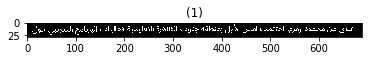

In [8]:
def SegmentImg2Lines(image):
    roi_list=[]
    gray = rgb2gray(image)
    
    #ret, threshed_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    #show_images([gray])
    kernel = np.ones((8,40), np.uint8)
    img_dilation = cv2.dilate(gray, kernel, iterations=1)
    # find contours
    #show_images([img_dilation])
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort contours
    #sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    for i, ctr in enumerate(ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)
        # Getting ROI
        roi = image[y:y + h, x:x + w]
        #show_images([roi])
        roi_list.append(roi)
    roi_list.reverse()
    return roi_list


def Segmentline2word(line):
    roi_list=[]
    locs=[]
    #gray = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)
    #ret, threshed_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    #show_images([threshed_img])
    gray = rgb2gray(line)
    kernel = np.ones((5,5), np.uint8)
    img_dilation = cv2.dilate(gray, kernel, iterations=1)
    show_images([img_dilation])
    # find contours
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort contours
    #sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    for i, ctr in enumerate(ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)
        # Getting ROI
        roi = line[y:y + h, x:x + w]
        #show_images([roi])
        locs.append((x, y, x + w,y + h))
        roi_list.append(roi)
    roi_list.reverse()
    locs.reverse()

    show_images([roi_list[0]])
    show_images([roi_list[3]])
    return roi_list,locs 

def main(thresh):
    
    #cv2.imshow('str',thresh/255)   

    lines=SegmentImg2Lines(thresh)
    show_images([lines[0]])


im = cv2.imread('input.png', cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY_INV)
#show_images([thresh])
main(thresh)